<a href="https://colab.research.google.com/github/jo1jun/Transformer/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import, device & dtype


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.long

# Multi Head Attention Layer

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, d_model, nhead, dropout_ratio):
        super().__init__()

        self.d_model = d_model # embed dimension
        self.nhead = nhead # head 수
        self.head_dim = d_model // nhead # head 마다의 dimension

        # paper 보면 d_model * d_k 이런 shape 인데, 실제 구현에서는 d_model * d_model 하고 나온 것을 쪼개서 multi head self attention 에 들어가게 함.
        self.qLinear = nn.Linear(d_model, d_model) # query lineqr
        self.kLinear = nn.Linear(d_model, d_model) # key linear
        self.vLinear = nn.Linear(d_model, d_model) # value linear
        self.oLinear = nn.Linear(d_model, d_model) # output linear

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]
        query_len = query.shape[1]
        value_len = key_len = key.shape[1]

        # query: [batch_size, query_len, d_model]
        # key: [batch_size, key_len, d_model]
        # value: [batch_size, value_len, d_model]
 
        Q = self.qLinear(query)
        K = self.kLinear(key)
        V = self.vLinear(value)

        # Q: [batch_size, query_len, d_model]
        # K: [batch_size, key_len, d_model]
        # V: [batch_size, value_len, d_model]

        # d_model = nhead * head_dim
        # head 수로 distribute
        Q = Q.reshape(batch_size, query_len, self.nhead, self.head_dim).transpose(1, 2)
        K = K.reshape(batch_size, key_len, self.nhead, self.head_dim).transpose(1, 2)
        V = V.reshape(batch_size, value_len, self.nhead, self.head_dim).transpose(1, 2)

        # Q: [batch_size, nhead, query_len, head_dim]
        # K: [batch_size, nhead, key_len, head_dim]
        # V: [batch_size, nhead, value_len, head_dim]

        # attention weight 계산
        weight = torch.matmul(Q, K.transpose(2, 3)) / np.sqrt(self.head_dim)

        # weight: [batch_size, nhead, query_len, key_len]

        if mask is not None:
            # mask 가 true 면 -1e9로 하여 softmax 값 0으로.
            weight = weight.masked_fill(mask, -1e9)

        attention = torch.softmax(weight, dim=-1) # TODO : softmax -1?

        # attention: [batch_size, nhead, query_len, key_len]

        # context vector 계산
        c = torch.matmul(self.dropout(attention), V)

        # c: [batch_size, nhead, query_len, head_dim]

        c = c.transpose(1, 2)

        # c: [batch_size, query_len, nhead, head_dim]

        # concat
        c = c.reshape(batch_size, query_len, self.d_model)

        # c: [batch_size, query_len, d_model]

        output = self.oLinear(c)

        # output: [batch_size, query_len, d_model]

        return output, attention

# Position-wise Feed Forward Layer

In [ ]:
class PositionWiseFeedForwardLayer(nn.Module):
    def __init__(self, d_model, ff_dim, dropout_ratio):
        super().__init__()

        self.linear1 = nn.Linear(d_model, ff_dim)
        self.linear2 = nn.Linear(ff_dim, d_model)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):

        # x: [batch_size, seq_len, d_model]

        x = self.dropout(torch.relu(self.linear1(x)))

        # x: [batch_size, seq_len, ff_dim]

        x = self.linear2(x)

        # x: [batch_size, seq_len, d_model]

        return x

# Encoder Layer

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, ff_dim, dropout_ratio):
        super().__init__()

        self.layerNorm1 = nn.LayerNorm(d_model)
        self.layerNorm2 = nn.LayerNorm(d_model)
        self.multiHeadAttentionLayer = MultiHeadAttentionLayer(d_model, nhead, dropout_ratio)
        self.positionWiseFeedForward = PositionWiseFeedForwardLayer(d_model, ff_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, src, src_mask):

        # src: [batch_size, src_len, d_model]
        # src_mask: [batch_size, src_len]

        # self attention 이므로 query, key, value 전부 동일
        _src, _ = self.multiHeadAttentionLayer(src, src, src, src_mask)

        # dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized
        src = self.layerNorm1(src + self.dropout(_src))

        # src: [batch_size, src_len, d_model]

        _src = self.positionWiseFeedForward(src)

        # dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized
        src = self.layerNorm2(src + self.dropout(_src))

        # src: [batch_size, src_len, d_model]

        return src

# Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, d_model, n_layers, nhead, ff_dim, dropout_ratio):
        super().__init__()

        # EncoderLayer 을 n_layers 만큼 반복.
        self.layers = nn.ModuleList([EncoderLayer(d_model, nhead, ff_dim, dropout_ratio) for _ in range(n_layers)])

    def forward(self, src, src_mask):

        # src: [batch_size, src_len]
        # src_mask: [batch_size, src_len]

        for layer in self.layers:
            src = layer(src, src_mask)

        # src: [batch_size, src_len, d_model]

        return src

# Decoder Layer

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, ff_dim, dropout_ratio):
        super().__init__()

        self.layerNorm1 = nn.LayerNorm(d_model)
        self.layerNorm2 = nn.LayerNorm(d_model)
        self.layerNorm3 = nn.LayerNorm(d_model)
        self.multiHeadAttentionLayer1 = MultiHeadAttentionLayer(d_model, nhead, dropout_ratio)
        self.multiHeadAttentionLayer2= MultiHeadAttentionLayer(d_model, nhead, dropout_ratio)
        self.positionWiseFeedForward = PositionWiseFeedForwardLayer(d_model, ff_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, tgt, enc_src, tgt_mask, src_mask):

        # tgt: [batch_size, tgt_len, d_model]
        # enc_src: [batch_size, src_len, d_model]
        # tgt_mask: [batch_size, tgt_len]
        # src_mask: [batch_size, src_len]

        # self attention
        _tgt, _ = self.multiHeadAttentionLayer1(tgt, tgt, tgt, tgt_mask)

        # dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized
        tgt = self.layerNorm1(tgt + self.dropout(_tgt))

        # tgt: [batch_size, tgt_len, d_model]

        # encoder attention
        # decoder 의 query, encdoer 의 key, value 로 attention
        _tgt, attention = self.multiHeadAttentionLayer2(tgt, enc_src, enc_src, src_mask)

        # dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized
        tgt = self.layerNorm2(tgt + self.dropout(_tgt))

        # tgt: [batch_size, tgt_len, d_model]

        # positionwise feedforward
        _tgt = self.positionWiseFeedForward(tgt)

        # dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized
        tgt = self.layerNorm3(tgt + self.dropout(_tgt))

        # tgt: [batch_size, tgt_len, d_model]
        # attention: [batch_size, nhead, tgt_len, src_len]

        return tgt, attention

# Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, d_model, n_layers, nhead, ff_dim, dropout_ratio):
        super().__init__()

        self.layers = nn.ModuleList([DecoderLayer(d_model, nhead, ff_dim, dropout_ratio) for _ in range(n_layers)])

        self.fc_out = nn.Linear(d_model, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, tgt, enc_src, tgt_mask, src_mask):

        # tgt: [batch_size, tgt_len]
        # enc_src: [batch_size, src_len, d_model]
        # tgt_mask: [batch_size, tgt_len]
        # src_mask: [batch_size, src_len]

        batch_size = tgt.shape[0]
        tgt_len = tgt.shape[1]

        # tgt: [batch_size, tgt_len, d_model]

        for layer in self.layers:
            tgt, attention = layer(tgt, enc_src, tgt_mask, src_mask)

        # tgt: [batch_size, tgt_len, d_model]
        # attention: [batch_size, nhead, tgt_len, src_len]

        output = self.fc_out(tgt)

        # output: [batch_size, tgt_len, output_dim]

        return output, attention

# Token & Positional Embedding

In [ ]:
class TokPosEmbedding(nn.Module):
  def __init__(self, input_dim, d_model, dropout_ratio):
    super().__init__()
    self.tokEmbedding = nn.Embedding(input_dim, d_model)
    self.posEmbedding = nn.Embedding(input_dim, d_model) # 위치 임베딩을 고정 함수가 아니라 학습하는 형태로 구현.
    self.d_model = d_model
    self.dropout = nn.Dropout(dropout_ratio)

  def forward(self, src):
    batch_size = src.shape[0]
    src_len = src.shape[1]

    pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(device) # 0 ~ src_len 등차 수열값 을 bactch 한개와 동일한 shape으로 생성
    
    # pos: [batch_size, src_len]

    src = self.dropout((self.tokEmbedding(src) * np.sqrt(self.d_model)) + self.posEmbedding(pos))

    # src: [batch_size, src_len, d_model]

    return src

# Transformer

In [ ]:
class Transformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, n_layers, nhead, ff_dim, dropout_ratio):
        super().__init__()

        self.encEmbedding = TokPosEmbedding(input_dim, d_model, dropout_ratio)
        self.encoder = Encoder(input_dim, d_model, n_layers, nhead, ff_dim, dropout_ratio)
        self.decEmbedding = TokPosEmbedding(output_dim, d_model, dropout_ratio)
        self.decoder = Decoder(output_dim, d_model, n_layers, nhead, ff_dim, dropout_ratio)

    def make_src_mask(self, src, pad):

        # src: [batch_size, src_len]

        # pad mask
        src_mask = (src.data.eq(pad)).unsqueeze(1).unsqueeze(2)

        # src_mask: [batch_size, 1, 1, src_len]
        return src_mask

    def make_tgt_mask(self, tgt, pad):
        
        # tgt: [batch_size, tgt_len]

        tgt_pad_mask = (tgt.data.eq(pad)).unsqueeze(1).unsqueeze(2)

        # tgt_pad_mask: [batch_size, 1, 1, tgt_len]

        tgt_len = tgt.shape[1]

        # chitting 방지 mask
        tgt_sub_mask = torch.triu(torch.ones((tgt_len, tgt_len))).bool().to(device)

        # tgt_sub_mask: [tgt_len, tgt_len] (upper triangular square matrix 형태)

        # mask 값이 true 면 fill 할 것이므로 pad_mask 와 or 연산.
        tgt_mask = tgt_pad_mask | tgt_sub_mask

        # tgt_mask: [batch_size, 1, tgt_len, tgt_len]

        return tgt_mask

    def forward(self, src, tgt, pad):

        # src: [batch_size, src_len]
        # tgt: [batch_size, tgt_len]

        src_mask = self.make_src_mask(src, pad)
        tgt_mask = self.make_tgt_mask(tgt, pad)

        # src_mask: [batch_size, 1, 1, src_len]
        # tgt_mask: [batch_size, 1, tgt_len, tgt_len]

        src = self.encEmbedding(src)
        tgt = self.decEmbedding(tgt)

        enc_src = self.encoder(src, src_mask)

        # enc_src: [batch_size, src_len, d_model]

        output, attention = self.decoder(tgt, enc_src, tgt_mask, src_mask)

        # output: [batch_size, tgt_len, output_dim]
        # attention: [batch_size, nhead, tgt_len, src_len]

        return output, attention

    def generate(self, src, start_id, sample_size, pad):

        batch_size = src.shape[0]

        src_mask = self.make_src_mask(src, pad)
        src = self.encEmbedding(src)
        enc_src = self.encoder(src, src_mask)
      
        sampled_tensor = torch.LongTensor([start_id]).unsqueeze(0).repeat(batch_size, 1).to(device)
        for _ in range(sample_size):

          tgt_mask = self.make_tgt_mask(sampled_tensor, pad)
          tgt = self.decEmbedding(sampled_tensor)
          probabilities, attention = self.decoder(tgt, enc_src, tgt_mask, src_mask)

          pred_token = probabilities.argmax(2)[:,-1].unsqueeze(1)

          sampled_tensor = torch.cat((sampled_tensor, pred_token), 1) # pred sentence 에 concat

        return sampled_tensor, attention


# Date format Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/dataset')
import sequence

# google mount 한 뒤 '/content/drive/MyDrive/' 에 dataset 저장 후 실행.

(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
# char -> id & id -> char dictionary
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)
print()

# 이미 id 화 되어있다.
print('question(id) : ', x_train[0])
print('correct(id)  : ',t_train[0])
print()

# sequence 확인 # ' ' : pad, '_' : start_char
print('question(char) : ', ' '.join([id_to_char[int(c)] for c in x_train[0]]))
print('correct(char)  : ', ' '.join([id_to_char[int(c)] for c in t_train[0]]))

vocab_size = len(char_to_id)
x_train = torch.Tensor(x_train)
t_train = torch.Tensor(t_train)
x_test = torch.Tensor(x_test)
t_test = torch.Tensor(t_test)
pad = 7 # pad token

(45000, 29)
(45000, 11)
(5000, 29)
(5000, 11)

question(id) :  [ 8 22  9 22  9  8  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7]
correct(id)  :  [14 11 12  9  8 15 16  8 15 16  9]

question(char) :  2 / 7 / 7 2                                              
correct(char)  :  _ 1 9 7 2 - 0 2 - 0 7


# hyperparameter

In [ ]:
batch_size = 128
epoch = 10
input_dim = output_dim = vocab_size
d_model = 32
n_layers = 1
nhead = 2
ff_dim = 1024
dropout_ratio = 0.1
learning_rate = 0.0025

In [ ]:
model = Transformer(input_dim, output_dim, d_model, n_layers, nhead, ff_dim, dropout_ratio)

In [ ]:
import torch.optim as optim

optimizer = torch.optim.Adam(model.parameters(), learning_rate)

criterion = nn.CrossEntropyLoss()

# Trainer

In [ ]:
def trainer(x, t, max_epoch, batch_size, model, optimizer, pad):

    data_size = len(x)
    max_iters = data_size // batch_size
    pad = torch.Tensor([pad]).to(device=device, dtype=dtype)

    model.train()
    model = model.to(device)
    for e in range(max_epoch):
        for iters in range(max_iters):
            batch_x = x[iters*batch_size:(iters+1)*batch_size]
            batch_t = t[iters*batch_size:(iters+1)*batch_size]

            batch_x = batch_x.to(device=device, dtype=dtype)
            batch_t = batch_t.to(device=device, dtype=dtype)

            # correct 값의 마지막 원소 배제 (end token 없음. 마지막 원소 다음 token 학습할 필요 x)
            scores, _ = model(batch_x, batch_t[:, :-1], pad)

            scores_dim = scores.shape[-1]

            scores = scores.reshape(-1, scores_dim)
            
            # correct 값의 첫 원소 배제
            batch_t = batch_t[:, 1:].reshape(-1)

            # scores  : [batch_size * tgt_len - 1, output_dim]
            # batch_t : [batch_size * tgt_len - 1]

            loss = criterion(scores, batch_t)

            optimizer.zero_grad()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0) # gradient clippling

            optimizer.step()

            if iters % 100 == 0:
                print('epoch[%d/%d] Iteration %d/%d, loss = %.4f' % (e+1, max_epoch, iters, max_iters, loss.item()))

# Train

In [ ]:
trainer(x_train, t_train, epoch, batch_size, model, optimizer, pad)

epoch[1/10] Iteration 0/351, loss = 4.3602
epoch[1/10] Iteration 100/351, loss = 0.9296
epoch[1/10] Iteration 200/351, loss = 0.7015
epoch[1/10] Iteration 300/351, loss = 0.4451
epoch[2/10] Iteration 0/351, loss = 0.4354
epoch[2/10] Iteration 100/351, loss = 0.3651
epoch[2/10] Iteration 200/351, loss = 0.2963
epoch[2/10] Iteration 300/351, loss = 0.2239
epoch[3/10] Iteration 0/351, loss = 0.1849
epoch[3/10] Iteration 100/351, loss = 0.2186
epoch[3/10] Iteration 200/351, loss = 0.1533
epoch[3/10] Iteration 300/351, loss = 0.1589
epoch[4/10] Iteration 0/351, loss = 0.1190
epoch[4/10] Iteration 100/351, loss = 0.1233
epoch[4/10] Iteration 200/351, loss = 0.1123
epoch[4/10] Iteration 300/351, loss = 0.1060
epoch[5/10] Iteration 0/351, loss = 0.1004
epoch[5/10] Iteration 100/351, loss = 0.1056
epoch[5/10] Iteration 200/351, loss = 0.0985
epoch[5/10] Iteration 300/351, loss = 0.0782
epoch[6/10] Iteration 0/351, loss = 0.0753
epoch[6/10] Iteration 100/351, loss = 0.0985
epoch[6/10] Iteration 

# Checker

In [ ]:
def checker(x, t, batch_size, model, pad):

    data_size = len(x)
    max_iters = data_size // batch_size
    pad = torch.Tensor([pad]).to(device=device, dtype=dtype)

    model.eval()
    with torch.no_grad():
      correct_num = 0
      for iters in range(max_iters):
        batch_x = x[iters*batch_size:(iters+1)*batch_size]
        batch_t = t[iters*batch_size:(iters+1)*batch_size]

        batch_x = batch_x.to(device=device, dtype=dtype)
        batch_t = batch_t.to(device=device, dtype=dtype)

        start_id = batch_t[0,0]
        correct = batch_t[:,1:]

        predict, _ = model.generate(batch_x, start_id, correct.shape[1], pad)
        predict = predict[:,1:]

        correct_num += (predict == correct).sum()
        
    return correct_num

# Accuracy

In [164]:
correct_num = checker(x_train, t_train, batch_size, model, pad)
acc = float(correct_num) / (t_train.shape[0] * (t_train.shape[1] - 1))
print('train accuracy %.3f%%' % (acc * 100))

correct_num = checker(x_test, t_test, batch_size, model, pad)
acc = float(correct_num) / (t_test.shape[0] * (t_test.shape[1] - 1))
print('test accuracy %.3f%%' % (acc * 100))

train accuracy 99.494%
test accuracy 99.398%


# Visualizing Attention

In [ ]:
def visualize(attention_map, row_labels, column_labels):
    fig = plt.figure(figsize=(20,5))
    h = attention_map.shape[0]
    for i, attention in enumerate(attention_map):
      ax = fig.add_subplot(1, h, i+1)
      ax.pcolor(attention, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

      ax.patch.set_facecolor('black')
      ax.set_yticks(np.arange(attention.shape[0])+0.5, minor=False)
      ax.set_xticks(np.arange(attention.shape[1])+0.5, minor=False)
      ax.invert_yaxis()
      ax.set_xticklabels(row_labels, minor=False)
      ax.set_yticklabels(column_labels, minor=False)

    plt.show()

## (x, y) = (question, predict X nhead)
### 학습 후 반복적으로 실행시켜 attention 이 잘 작동하는 것을 확인할 수 있다.
### 가로 축 2개 head 마다의 attention, 세로 축으로 5개의 sample.

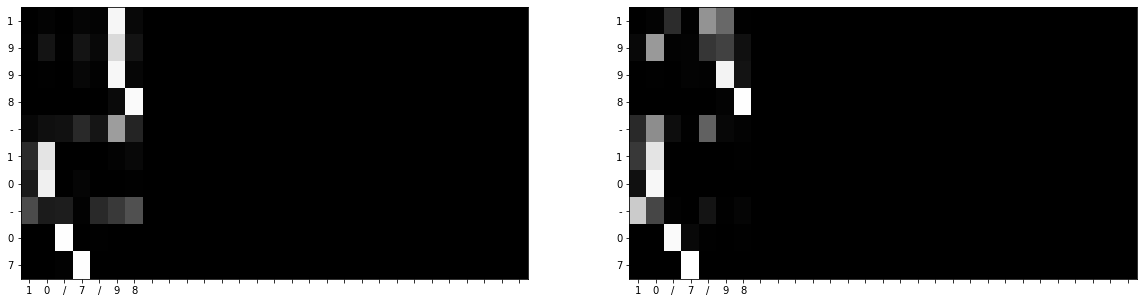

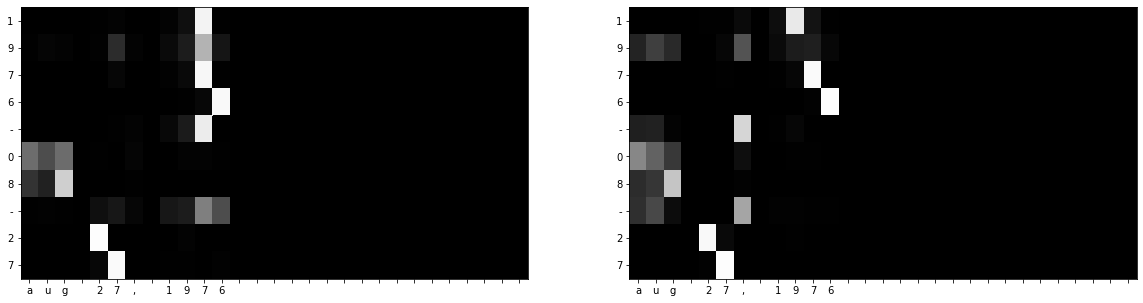

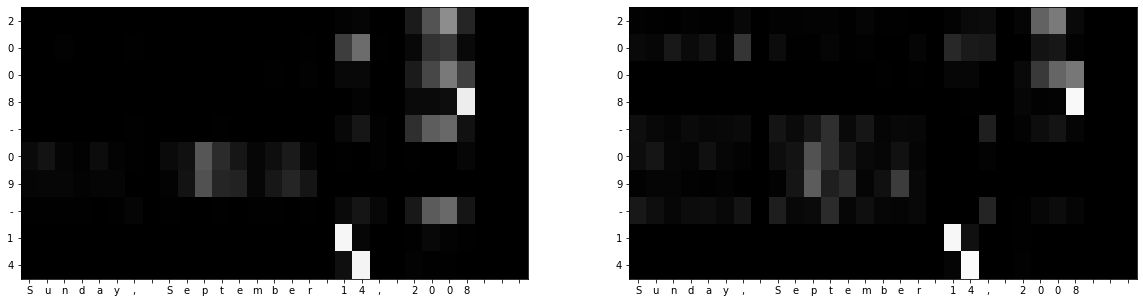

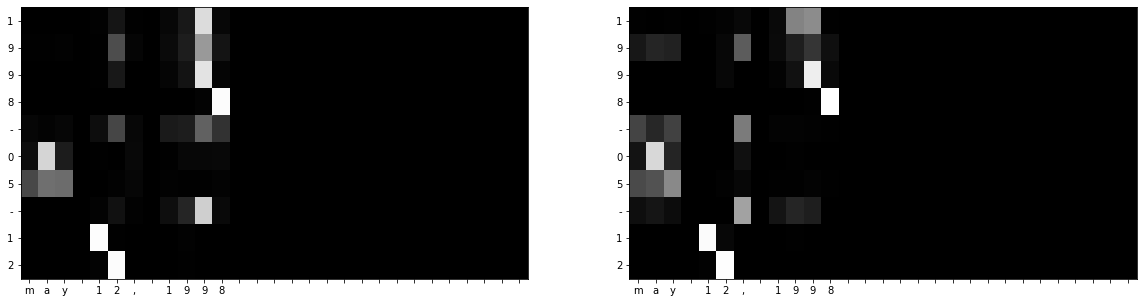

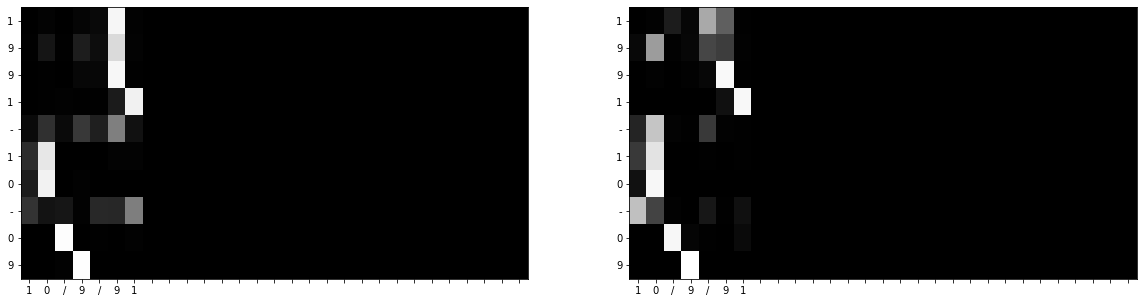

In [ ]:
for _ in range(5):
  idx = [np.random.randint(0, len(x_test))]

  question = x_test[idx].to(device, dtype)
  correct = t_test[idx].to(device, dtype)
  pad = torch.Tensor([pad]).to(device=device, dtype=dtype)

  correct = correct.flatten()
  # 머릿글자
  start_id = correct[0]

  correct = correct[1:]
  with torch.no_grad():
    predict, attention  = model.generate(question, start_id, len(correct), pad)
  predict = predict[:,1:]

  # 문자열로 변환
  question = [id_to_char[int(c)] for c in question.flatten()]
  correct = [id_to_char[int(c)] for c in correct.flatten()]
  predict = [id_to_char[int(c)] for c in predict.flatten()]

  visualize(attention.squeeze(0).cpu().numpy(), question, predict)